# Exploring the regine network with TEOTIL

**Important setup**

To install TEOTIL in development mode, you first need to **clone the repository to your local Hub workspace**. Then, the following steps are required **each time you start a new JupyterHub server**:

 1. Install TEOTIL3 in development mode by running the code cell below.
 
 2. Restart the notebook kernel (so the newly installed TEOTIL is discoverable).

In [1]:
# Run this and then restart the kernel at the start of each session to install 'teotil3' in development mode.
# Adjust the file path to match the location where you cloned the 'teotil3' repo.
# After installing, COMMENT OUT this code again, so you don't reinstall TEOTIL every time you re-run the notebook.
# You only need to run this cell ONCE when you first start your server. TEOTIL is then available to all notebooks
# for the duration of your session.
# Remember to restart the kernel after installing, otherwise you'll get an error "No module named teotil3"
# !pip install -e /home/jovyan/teotil3/

In [2]:
import pprint as pp

import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


## 1. Get regine data

In [4]:
# Get regine polygons
admin_year = 2022  # Year for admin. boundaries
reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year)

# Determine hydrological connectivity. See docstring for details
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)

# Build network graph from adjacency matrix
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

reg_gdf.head()

/home/jovyan/teotil3/teotil3/io.py:288: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  gdf.set_geometry("geometry", drop=False, inplace=True)
/home/jovyan/teotil3/teotil3/io.py:233: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col]

100.00 % of regines assigned.


,regine,regine_down,vassom,a_cat_poly_km2,ospar_region,komnr,fylnr,a_agri_km2,a_glacier_km2,a_lake_km2,...,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_cat_land_km2,a_lake_nve_km2,runoff_mm/yr,q_cat_m3/s,geometry
0,001.10,001.,001,1.442790,Skagerrak,3001,30,0.000000,0.0,0.000013,...,0.281940,0.000000,0.000000,0.849188,0.849201,1.160850,0.000000,592.0,0.02178,"MULTIPOLYGON (((297006.83 6543966.95, 297169.2..."
1,001.1A1,001.,001,1.432479,Skagerrak,3001,30,0.000000,0.0,0.048098,...,0.000067,0.004615,0.000000,1.377476,1.430189,1.432412,0.043955,620.0,0.02814,"MULTIPOLYGON (((297505.44 6543157.79, 297543.1..."
2,001.1A20,001.1A1,001,0.340160,Skagerrak,3001,30,0.000000,0.0,0.036623,...,0.000045,0.000000,0.000000,0.303492,0.340114,0.340114,0.000000,594.0,0.00640,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001.1A20,001,17.647822,Skagerrak,3001,30,1.895549,0.0,0.122567,...,0.000000,0.467374,0.131585,15.030746,17.647822,17.647822,0.186340,637.0,0.35623,"MULTIPOLYGON (((299678.37 6544460.32, 299667.2..."
4,001.1A2B,001.1A2A,001,41.298255,Skagerrak,3001,30,1.573851,0.0,7.513687,...,0.000000,2.250799,0.161524,29.798394,41.298255,41.298255,7.344123,637.0,0.83362,"MULTIPOLYGON (((303353.46 6552989.33, 303341.6..."


Local attributes for catchment '002.A4':
{'a_agri_km2': 1.547369,
 'a_cat_land_km2': 10.913873,
 'a_cat_poly_km2': 10.913873,
 'a_glacier_km2': 0.0,
 'a_lake_km2': 0.578136,
 'a_lake_nve_km2': 0.006713,
 'a_other_km2': 0.0,
 'a_sea_km2': 0.0,
 'a_upland_km2': 0.211754,
 'a_urban_km2': 7.893002,
 'a_wood_km2': 0.683613,
 'ar50_tot_a_km2': 10.913873,
 'fylnr': '30',
 'geometry': <MULTIPOLYGON (((276684.82 6579303.26, 277054.36 6579168.43, 277355.85 65792...>,
 'komnr': '3003',
 'ospar_region': 'Skagerrak',
 'q_cat_m3/s': 0.14076,
 'regine': '002.A4',
 'regine_down': '002.A3',
 'runoff_mm/yr': 407.0,
 'vassom': '002'}


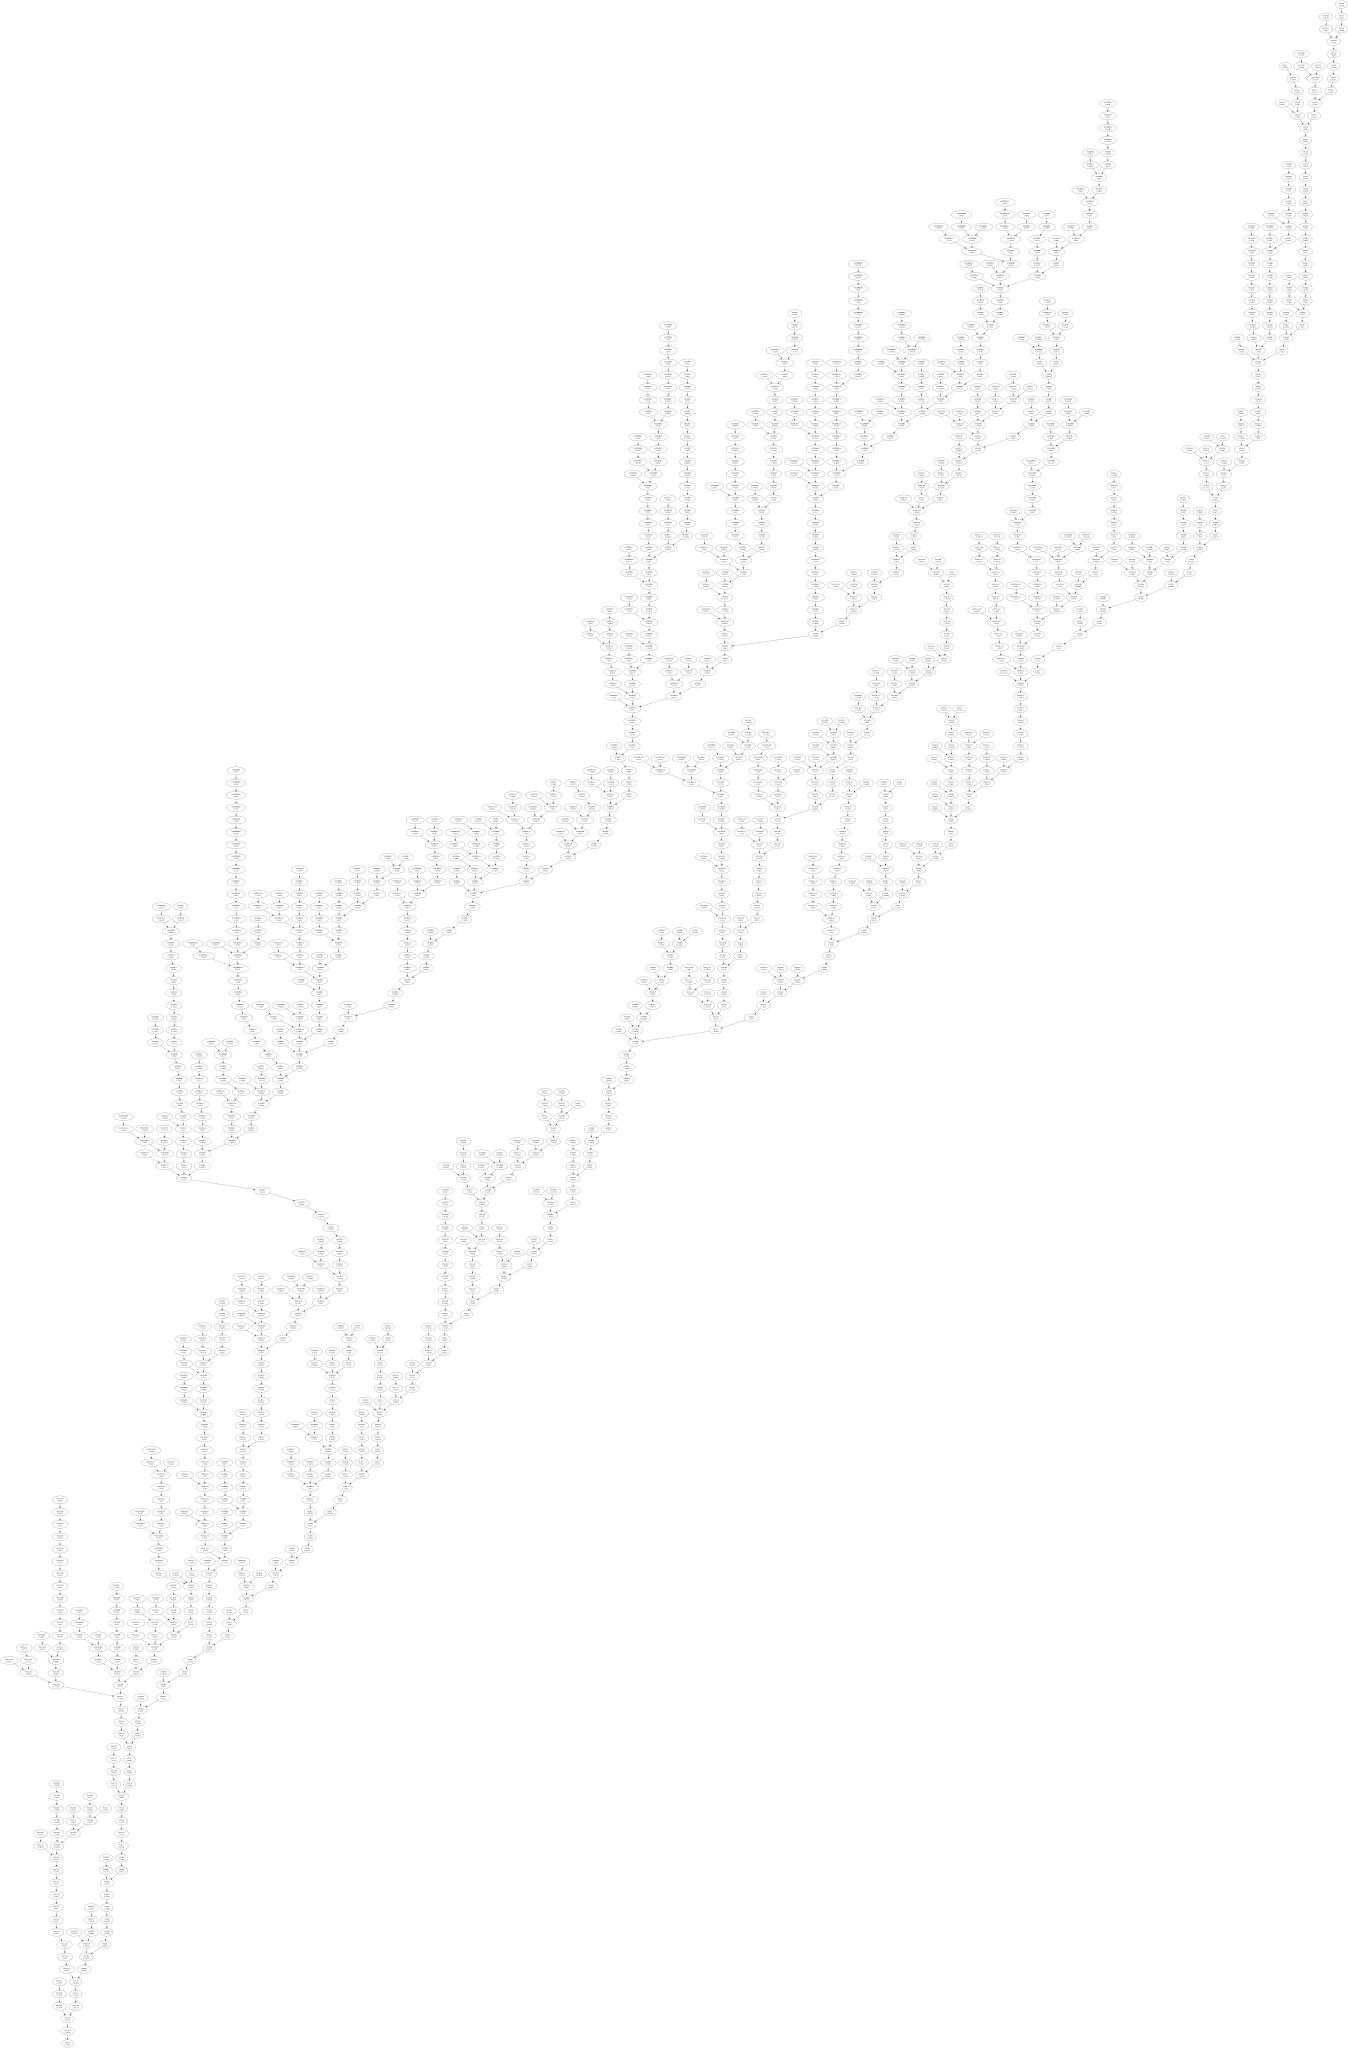

In [5]:
# Catchment of interest
reg_id = "002.A4"

# Get 'local' data for catchment
print(f"Local attributes for catchment '{reg_id}':")
pp.pprint(g.nodes[reg_id]["local"])

# Plot network upstream
teo.vis.plot_network(g, reg_id, direct="up", stat="local", quant="a_cat_land_km2")

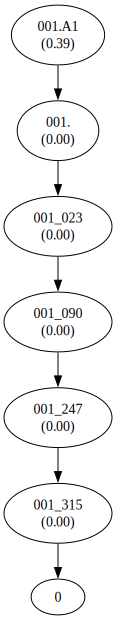

In [6]:
# Plot network downstream
teo.vis.plot_network(g, reg_id, direct="down", stat="local", quant="a_cat_land_km2")

<Axes: >

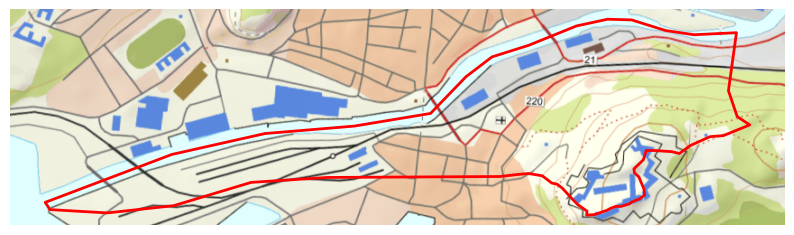

In [7]:
# Plot just the specified regine
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=False
)
ax

<Axes: >

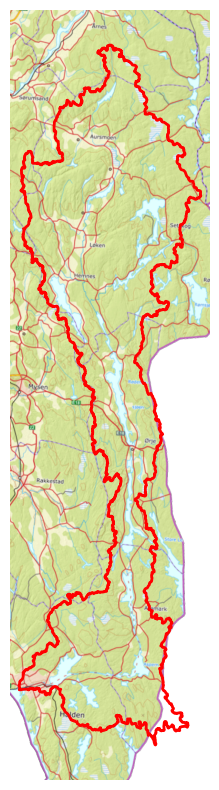

In [8]:
# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

In [9]:
gdf.head()

,geometry,regine,regine_down,vassom,a_cat_poly_km2,ospar_region,komnr,fylnr,a_agri_km2,a_glacier_km2,...,a_other_km2,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_cat_land_km2,a_lake_nve_km2,runoff_mm/yr,q_cat_m3/s
0,"POLYGON ((301508.310 6553788.360, 301456.730 6...",001.A1,001.,001,0.425051,Skagerrak,3001,30,0.0,0.0,...,0.0,0.032787,0.004263,0.260211,0.116499,0.392264,0.392264,0.0,431.0,0.00536


In [ ]:
# Plot the specified regine and other regines on the downstream path
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="down"
)
ax

## 2. Explore model results

**These model results are provisional**: they're read from the folder where I'm evaluating TEOTIL3 against observed data, so they change as I tweak things. Results are fairly stable now, but may change without warning.

In [3]:
# Read provisional TEOTIL3 results for 2013 to 2022
mod_csv = (
    r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022.csv"
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,123.574401,0.752367,3.420677,6341.957239,68.505729,192.080130,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712746,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


In [4]:
mod_df.columns

Index(['regine', 'regine_down', 'accum_agriculture-background_din_kg',
       'accum_agriculture-background_ss_kg',
       'accum_agriculture-background_tdp_kg',
       'accum_agriculture-background_toc_kg',
       'accum_agriculture-background_ton_kg',
       'accum_agriculture-background_totn_kg',
       'accum_agriculture-background_totp_kg',
       'accum_agriculture-background_tpp_kg',
       ...
       'local_urban_tpp_kg', 'local_wood_din_kg', 'local_wood_ss_kg',
       'local_wood_tdp_kg', 'local_wood_toc_kg', 'local_wood_ton_kg',
       'local_wood_totn_kg', 'local_wood_totp_kg', 'local_wood_tpp_kg',
       'year'],
      dtype='object', length=164)

In [6]:
# Get just "accumulated" results for the Oslofjord main vassdragsområder
year = 2022
vass_min, vass_max = 1, 14
par = "din"

cols = ["regine", "year"] + [
    col for col in mod_df.columns if f"_{par}_" in col and col.startswith("accum")
]
vass_list = [f"{vass:03d}." for vass in range(vass_min, vass_max + 1)]
osl_df = (
    mod_df.query("(year == @year) and (regine in @vass_list)")[cols]
    .copy()
    .reset_index(drop=True)
)
print(osl_df.columns)
osl_df.head()

Index(['regine', 'year', 'accum_agriculture-background_totn_kg',
       'accum_agriculture_totn_kg', 'accum_aquaculture_totn_kg',
       'accum_industry_totn_kg', 'accum_lake_totn_kg',
       'accum_large-wastewater_totn_kg', 'accum_spredt_totn_kg',
       'accum_upland_totn_kg', 'accum_urban_totn_kg', 'accum_wood_totn_kg'],
      dtype='object')


,regine,year,accum_agriculture-background_totn_kg,accum_agriculture_totn_kg,accum_aquaculture_totn_kg,accum_industry_totn_kg,accum_lake_totn_kg,accum_large-wastewater_totn_kg,accum_spredt_totn_kg,accum_upland_totn_kg,accum_urban_totn_kg,accum_wood_totn_kg
0,004.,2022,21092.664465,189833.980183,0.0,0.0,122.100000,154037.100000,12284.100000,260.300000,12725.100000,14865.200000
1,005.,2022,12948.968989,116540.720898,0.0,0.0,2123.359012,49084.806665,16188.177216,251.106335,18889.369947,17327.139860
2,010.,2022,3181.674023,28635.066210,0.0,0.0,1012.393928,12223.700000,3066.494152,39.870483,3108.251247,8629.344932
3,013.,2022,23383.032581,210447.293229,0.0,20680.0,2026.520101,481198.900000,14277.984027,583.194834,23341.662742,26900.539659
4,008.,2022,5388.075311,48492.677796,0.0,0.0,1243.237775,404.100000,2517.697301,818.514214,40047.039154,28902.896227
